# Neural Networks and Embeddings for Natural Language Processing

Outline:
- Download the Data
- Prepare Data for Training
- Logistic Regression Model
- Feed Forward Nueral Network


Dataset: https://www.kaggle.com/c/quora-insincere-questions-classification

## Download the Data

Upload your `kaggle.json` file to Colab

In [1]:
!ls
import os
IS_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

sample_data


In [2]:
if IS_KAGGLE:
    data_dir = '../input/quora-insincere-questions-classification'
    train_fname = data_dir + '/train.csv'
    test_fname = data_dir + '/test.csv'
    sub_fname = data_dir + '/sample_submission.csv'
else:
    os.environ['KAGGLE_CONFIG_DIR'] = '.'
    !kaggle competitions download -c quora-insincere-questions-classification -f train.csv -p data
    !kaggle competitions download -c quora-insincere-questions-classification -f test.csv -p data
    !kaggle competitions download -c quora-insincere-questions-classification -f sample_submission.csv -p data
    train_fname = 'data/train.csv.zip'
    test_fname = 'data/test.csv.zip'
    sub_fname = 'data/sample_submission.csv.zip'

 91% 50.0M/54.9M [00:00<00:00, 77.1MB/s]
100% 54.9M/54.9M [00:00<00:00, 75.4MB/s]
 32% 5.00M/15.8M [00:00<00:00, 22.5MB/s]
100% 15.8M/15.8M [00:00<00:00, 58.8MB/s]
  0% 0.00/4.09M [00:00<?, ?B/s]
100% 4.09M/4.09M [00:00<00:00, 43.5MB/s]


In [3]:
import pandas as pd

In [4]:
raw_df = pd.read_csv(train_fname)
test_df = pd.read_csv(test_fname)
sub_df = pd.read_csv(sub_fname)

In [5]:
raw_df

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


In [6]:
  if IS_KAGGLE:
    sample_df = raw_df
else:
    sample_df = raw_df.sample(100_000, random_state=42)

## Prepare Data for Training


Outline:
- Convert text to TF-IDF Vectors
- Split training & validation set
- Convert to PyTorch tensors

### Conversion to TF-IDF Vectors

In [9]:
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import  TfidfVectorizer

In [10]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
stemmer = SnowballStemmer('english')

def tokenize(text):
    return [ stemmer.stem(token) for token in word_tokenize(text)]


In [13]:
tokenize("Ain't nothin' (but a heartache)!")

['ai', "n't", 'nothin', "'", '(', 'but', 'a', 'heartach', ')', '!']

In [14]:
english_stopwords = stopwords.words('english')

In [15]:
vectorizer = TfidfVectorizer(lowercase=True, tokenizer=tokenize , stop_words=english_stopwords, max_features=1000)

In [18]:
%%time
vectorizer.fit(sample_df.question_text)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


CPU times: user 48.6 s, sys: 201 ms, total: 48.8 s
Wall time: 1min 9s


TfidfVectorizer(max_features=1000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x793d58bdb760>)

In [27]:
%%time
inputs = vectorizer.transform(sample_df.question_text)

CPU times: user 46.3 s, sys: 186 ms, total: 46.5 s
Wall time: 1min 2s


In [28]:
inputs.shape

(100000, 1000)

In [29]:
targets = sample_df.target.values
targets.shape

(100000,)

In [30]:
%%time
test_inputs = vectorizer.transform(test_df.question_text)

CPU times: user 2min 37s, sys: 662 ms, total: 2min 38s
Wall time: 3min 25s


### Split training and validation set

In [31]:
from sklearn.model_selection import train_test_split

In [34]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs, targets, test_size=0.2, random_state=42)

In [35]:
train_inputs.shape, val_inputs.shape

((80000, 1000), (20000, 1000))

In [36]:
train_targets.shape

(80000,)

### Convert to PyTorch Tensors

In [38]:
import torch
from torch.utils.data import TensorDataset , DataLoader

import torch.nn.functional as F


In [39]:
train_tensors  = F.normalize(torch.tensor(train_inputs.toarray()).float(),dim=1)
val_tensors = F.normalize(torch.tensor(val_inputs.toarray()).float(),dim=1)

In [40]:
train_tensors.shape , val_tensors.shape

(torch.Size([80000, 1000]), torch.Size([20000, 1000]))

In [42]:
train_ds = TensorDataset(train_tensors, torch.tensor(train_targets))
val_ds = TensorDataset(val_tensors, torch.tensor(val_targets))

In [43]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)

In [45]:
for inputs_batch , targets_batch in train_dl:
    print(inputs_batch.shape)
    print(targets_batch.shape)
    print(targets_batch)
    break

torch.Size([128, 1000])
torch.Size([128])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


## Logistic Regression Model

In [46]:
import torch.nn as nn

In [47]:
class LogReg(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(1000,1)

  def forward(self, xb):
    out = self.linear(xb)
    return out

In [50]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

In [51]:
logreg_model = LogReg()

In [53]:
for batch in val_dl:
    batch_inputs, batch_targets = batch
    print('inputs.shape', batch_inputs.shape)
    print('targets', batch_targets)

    batch_out = logreg_model(batch_inputs)
    probs = torch.sigmoid(batch_out[:,0])
    preds = (probs >= 0.5).int()

    print('outputs', preds)
    print('accuracy', accuracy_score(batch_targets, preds))
    print('f1_score', f1_score(batch_targets, preds))
    break

inputs.shape torch.Size([128, 1000])
targets tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0])
outputs tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 0], dtype=torch.int32)
accuracy 0.265625
f1_score 0.12962962962962962


In [54]:
def evaluate(model, dl):
    losses, accs, f1s = [], [], []
    for batch in dl:
        inputs, targets = batch
        out = model(inputs)

        probs = torch.sigmoid(out[:,0])
        loss = F.binary_cross_entropy(probs, targets.float(), weight=torch.tensor(20.))
        losses.append(loss.item())

        preds = (probs > 0.5).int()
        acc = accuracy_score(targets, preds)
        f1 = f1_score(targets, preds)

        accs.append(acc)
        f1s.append(f1)

    return np.mean(losses), np.mean(accs), np.mean(f1s)

In [55]:
def fit(epochs, lr, model, train_loader, val_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-5)
    history = [] # for recording epoch-wise results

    for epoch in range(epochs):

        # Training Phase
        for batch in train_loader:
            inputs, targets = batch
            out = model(inputs)
            probs = torch.sigmoid(out[:,0])
            loss = F.binary_cross_entropy(probs,
                                          targets.float(),
                                          weight=torch.tensor(20.))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        loss, acc, f1 = result
        print('Epoch: {}; Loss: {:.4f}; Accuracy: {:.4f}; F1 Score: {:.4f}'.format(
            epoch, loss, acc, f1))
        history.append(result)

    return history

In [56]:
logreg_model = LogReg()

In [58]:
history = [evaluate(logreg_model, val_dl)]
history

[(14.062603087941552, 0.16057921974522293, 0.1163079100010057)]

In [61]:
history += fit(5, 0.01, logreg_model, train_dl, val_dl)

Epoch: 0; Loss: 3.4510; Accuracy: 0.9401; F1 Score: 0.0722
Epoch: 1; Loss: 3.1571; Accuracy: 0.9436; F1 Score: 0.2124
Epoch: 2; Loss: 3.0725; Accuracy: 0.9446; F1 Score: 0.2826
Epoch: 3; Loss: 3.0423; Accuracy: 0.9450; F1 Score: 0.3098
Epoch: 4; Loss: 3.0204; Accuracy: 0.9458; F1 Score: 0.3416


In [62]:
history += fit(5, 0.01, logreg_model, train_dl, val_dl)

Epoch: 0; Loss: 3.0318; Accuracy: 0.9457; F1 Score: 0.3491
Epoch: 1; Loss: 3.0256; Accuracy: 0.9454; F1 Score: 0.3409
Epoch: 2; Loss: 3.0195; Accuracy: 0.9461; F1 Score: 0.3504
Epoch: 3; Loss: 3.0101; Accuracy: 0.9462; F1 Score: 0.3723
Epoch: 4; Loss: 3.0033; Accuracy: 0.9462; F1 Score: 0.3672


In [63]:
history += fit(5, 0.01, logreg_model, train_dl, val_dl)

Epoch: 0; Loss: 3.0160; Accuracy: 0.9459; F1 Score: 0.3699
Epoch: 1; Loss: 3.0087; Accuracy: 0.9464; F1 Score: 0.3747
Epoch: 2; Loss: 3.0017; Accuracy: 0.9464; F1 Score: 0.3699
Epoch: 3; Loss: 2.9981; Accuracy: 0.9465; F1 Score: 0.3880
Epoch: 4; Loss: 2.9896; Accuracy: 0.9462; F1 Score: 0.3731


In [64]:
losses = [item[0] for item in history]

Text(0.5, 1.0, 'Loss')

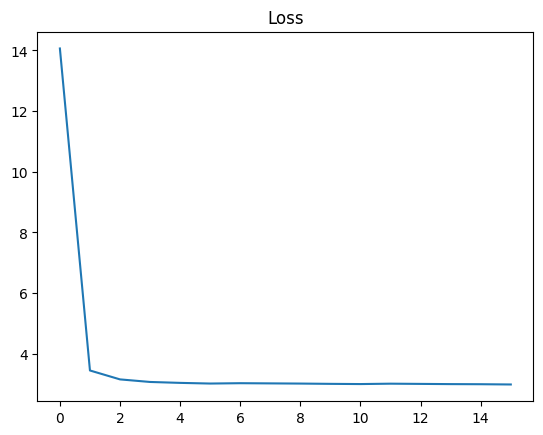

In [67]:
import matplotlib.pyplot as plt
plt.plot(losses);
plt.title('Loss')

In [68]:
f1s = [item[2] for item in history]

Text(0.5, 1.0, 'F1 Score')

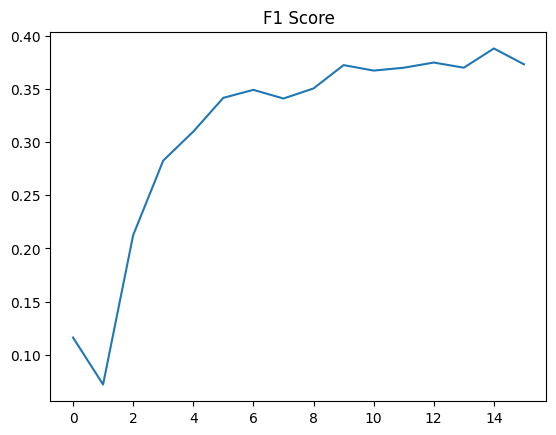

In [69]:
plt.plot(f1s)
plt.title('F1 Score')

## Feed Forward Neural Network

In [70]:
import torch.nn.functional as F

In [71]:
class FeedForwardModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(1000, 512)
    self.linear2 = nn.Linear(512, 256)
    self.linear3 = nn.Linear(256, 128)
    self.linear4 = nn.Linear(128, 1)

  def forward(self, xb):
    out = F.relu(self.linear1(xb))
    out = F.relu(self.linear2(out))
    out = F.relu(self.linear3(out))
    out = self.linear4(out)
    return out

In [72]:
ff_model = FeedForwardModel()

In [73]:
history = [evaluate(ff_model, val_dl)]
history

[(14.003177187245363, 0.060360270700636945, 0.11312669818892775)]

In [74]:
%%time
history += fit(5, 0.001, ff_model, train_dl, val_dl)

Epoch: 0; Loss: 3.0411; Accuracy: 0.9448; F1 Score: 0.3138
Epoch: 1; Loss: 2.9714; Accuracy: 0.9474; F1 Score: 0.4319
Epoch: 2; Loss: 3.0807; Accuracy: 0.9454; F1 Score: 0.4284
Epoch: 3; Loss: 3.7690; Accuracy: 0.9424; F1 Score: 0.4222
Epoch: 4; Loss: 5.2981; Accuracy: 0.9409; F1 Score: 0.3350
CPU times: user 2min 9s, sys: 352 ms, total: 2min 10s
Wall time: 2min 21s


## Make Predictions and Submit

In [75]:
test_tensors = torch.tensor(test_inputs.toarray()).float()

In [76]:
test_ds = TensorDataset(test_tensors)

In [77]:
test_dl = DataLoader(test_ds, batch_size)

In [78]:
def predict(model, dl):
    all_preds = []
    for batch in dl:
        inputs, = batch
        out = model(inputs)
        probs = torch.sigmoid(out)[:,0]
        preds = (probs > 0.5).int()
        all_preds += list(preds.numpy())
    return all_preds

In [79]:
test_preds = predict(ff_model, test_dl)

In [80]:
test_preds[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [81]:
sub_df

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0


In [82]:
sub_df.prediction = test_preds

In [83]:
sub_df.to_csv('submission.csv', index=None)

In [84]:
!head submission.csv

qid,prediction
0000163e3ea7c7a74cd7,0
00002bd4fb5d505b9161,0
00007756b4a147d2b0b3,0
000086e4b7e1c7146103,0
0000c4c3fbe8785a3090,0
000101884c19f3515c1a,0
00010f62537781f44a47,0
00012afbd27452239059,0
00014894849d00ba98a9,0
